In [1]:
# --------------------
# Step 1: Import necessary libraries
# --------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import os
import random

In [2]:
# --------------------
# Step 2: Batch size
# --------------------
batch_size = 32
IMAGE_SIZE = 224  # DenseNet121 expects at least 224x224

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the dataset path in Google Drive
# Change this path to where your dataset folder is stored in your Drive
DATA_PATH = '/content/drive/MyDrive/Tea Leaf Updated'

Mounted at /content/drive


In [4]:
# --------------------
# Step 4: Set seeds for reproducibility
# --------------------
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
# --------------------
# Step 5: Load dataset with tf.keras
# --------------------
data_dir = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size
)

Found 2497 files belonging to 4 classes.


In [6]:
# --------------------
# Step 6: Class names
# --------------------
class_names = data_dir.class_names
print(f"Class names: {class_names}")
print(f"Dataset length (batches): {len(data_dir)}")

Class names: ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
Dataset length (batches): 79


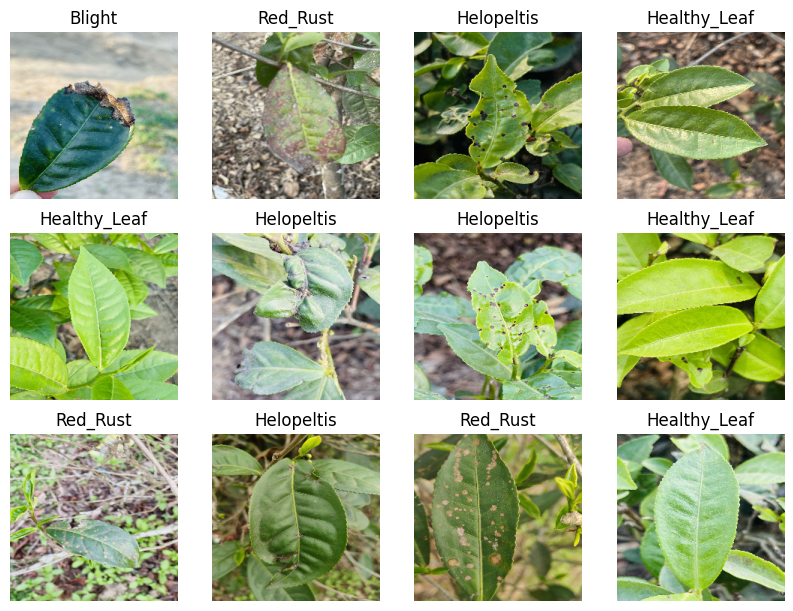

In [7]:
# --------------------
# Step 7: Visualize sample images
# --------------------
plt.figure(figsize=(10,10))
for image_batch, label_batch in data_dir.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
# --------------------
# Step 8 & 12: Train/Validation/Test split
# --------------------
train_size = 0.8
val_size = 0.1
test_size = 0.1

dataset_size = len(data_dir)
train_batches = int(train_size * dataset_size)
val_batches = int(val_size * dataset_size)

train_ds = data_dir.take(train_batches)
val_ds = data_dir.skip(train_batches).take(val_batches)
test_ds = data_dir.skip(train_batches + val_batches)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# --------------------
# Step 13: Data augmentation
# --------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [10]:
# --------------------
# Step 15 & 16: DenseNet121 model
# --------------------
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False  # Freeze base model for transfer learning

model = models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')  # 4 classes
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
# --------------------
# Step 16: Compile model
# --------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# --------------------
# Step 17: Model summary
# --------------------
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [13]:
# --------------------
# Step 18: Callbacks
# --------------------
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [14]:
# --------------------
# Step 19: Training
# --------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3287 - loss: 1.4414

63/63 ━━━━━━━━━━━━━━━━━━━━ 808s 13s/step - accuracy: 0.3303 - loss: 1.4388 - val_accuracy: 0.7054 - val_loss: 0.8409
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6286 - loss: 0.9051

63/63 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.6290 - loss: 0.9043 - val_accuracy: 0.7545 - val_loss: 0.6770
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7233 - loss: 0.7442

63/63 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.7234 - loss: 0.7437 - val_accuracy: 0.8036 - val_loss: 0.5507
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7511 - loss: 0.6677

63/63 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.7513 - loss: 0.6671 - val_accuracy: 0.7902 - val_loss: 0.5346
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7955 - loss: 0.5700

63/63 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.7955 - loss: 0.5699 - val_accuracy: 0.7768 - val_loss: 0.5139
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8100 - loss: 0.5483

63/63 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.8100 - loss: 0.5479 - val_accuracy: 0.8348 - val_loss: 0.4616
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.8136 - loss: 0.5173 - val_accuracy: 0.7812 - val_loss: 0.5046
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.8318 - loss: 0.4832 - val_accuracy: 0.8125 - val_loss: 0.4779
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.8291 - loss: 0.4604 - val_accuracy: 0.7902 - val_loss: 0.5261
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8296 - loss: 0.4512

63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.8297 - loss: 0.4511 - val_accuracy: 0.8705 - val_loss: 0.3952
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.8447 - loss: 0.4407 - val_accuracy: 0.8527 - val_loss: 0.4130
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.8345 - loss: 0.4266 - val_accuracy: 0.8393 - val_loss: 0.4053
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8496 - loss: 0.4114

63/63 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.8497 - loss: 0.4114 - val_accuracy: 0.8795 - val_loss: 0.3618
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8645 - loss: 0.3934

63/63 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.8645 - loss: 0.3934 - val_accuracy: 0.8750 - val_loss: 0.3327
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.8518 - loss: 0.3935 - val_accuracy: 0.8839 - val_loss: 0.3397
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.8630 - loss: 0.3894 - val_accuracy: 0.8482 - val_loss: 0.3925
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8630 - loss: 0.3565

63/63 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.8631 - loss: 0.3566 - val_accuracy: 0.8839 - val_loss: 0.3246
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.8801 - loss: 0.3577 - val_accuracy: 0.8750 - val_loss: 0.3422
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.8691 - loss: 0.3513 - val_accuracy: 0.8705 - val_loss: 0.4067
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.8772 - loss: 0.3518 - val_accuracy: 0.8795 - val_loss: 0.3515


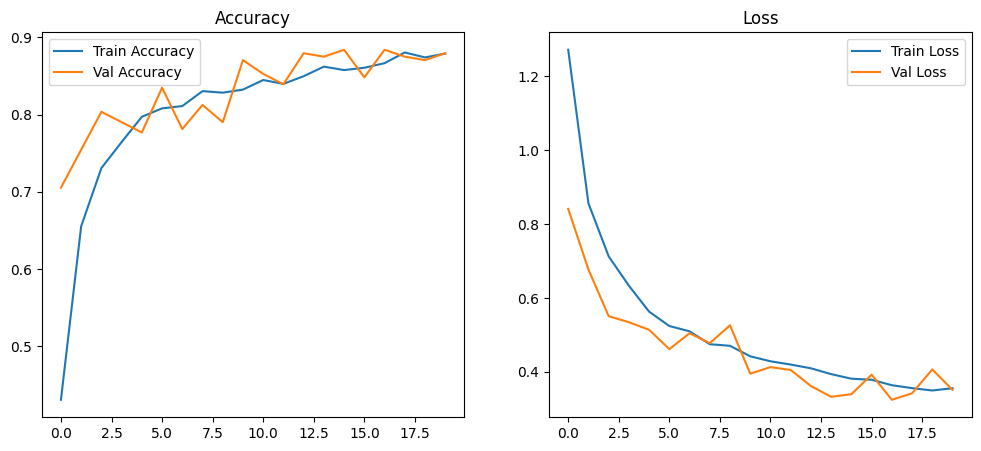

In [15]:
# --------------------
# Step 20: Plot accuracy & loss
# --------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Classification Report:
              precision    recall  f1-score   support

      Blight       0.81      0.77      0.79        66
Healthy_Leaf       0.87      0.92      0.89        77
  Helopeltis       0.96      0.79      0.87        57
    Red_Rust       0.68      0.77      0.72        57

    accuracy                           0.82       257
   macro avg       0.83      0.81      0.82       257
weighted avg       0.83      0.82      0.82       257



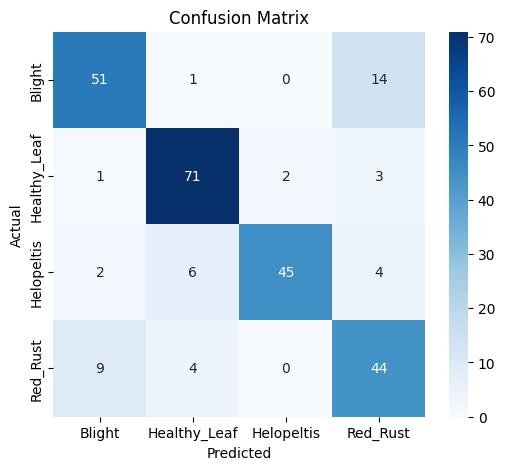

In [16]:
# --------------------
# Step 21-22: Classification report & confusion matrix
# --------------------
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()